In [122]:
from sympy import symbols, solve, log, diff
from scipy.optimize import minimize_scalar, newton, minimize
from scipy.integrate import quad
from scipy.stats import norm
import numpy as np
import pandas as pd
from numpy.linalg import inv
import matplotlib.pyplot as plt
from numpy.random import dirichlet

In [26]:
%matplotlib inline
plt.style.use('fivethirtyeight')
np.random.seed(42)

In [2]:
share, odds, probability = symbols('share odds probability')
Value = probability * log(1 + odds * share) + (1 - probability) * log(1 - share)
solve(diff(Value, share), share)

[(odds*probability + probability - 1)/odds]

In [3]:
f, p = symbols('f p')
y = p * log(1 + f) + (1 - p) * log(1 - f)
solve(diff(y, f), f)

[2*p - 1]

In [12]:
with pd.HDFStore('../../00_data/assets.h5') as store:
    sp500 = store['sp500/prices'].close

In [77]:
annual_returns = sp500.resample('A').last().pct_change().to_frame('sp500')

In [78]:
return_params = annual_returns.sp500.rolling(25).agg(['mean', 'std']).dropna()

In [79]:
return_ci = (return_params[['mean']]
                .assign(lower=return_params['mean'].sub(return_params['std'].mul(2)))
                .assign(upper=return_params['mean'].add(return_params['std'].mul(2))))

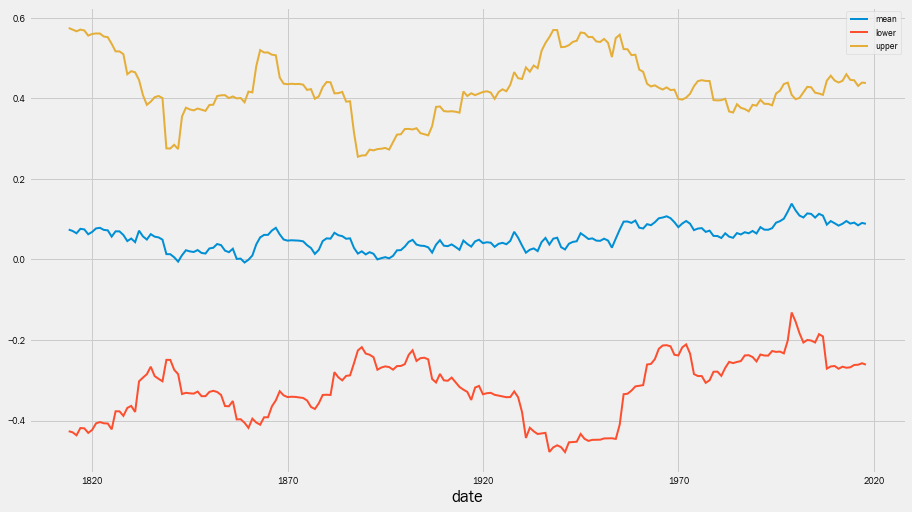

In [80]:
return_ci.plot(lw=2, figsize=(14, 8));

In [64]:
def norm_integral(f, mean, std):
    val, er = quad(lambda s: np.log(1 + f * s) * norm.pdf(s, mean, std), 
                               mean - 3 * std, 
                               mean + 3 * std)
    return -val

In [49]:
def norm_dev_integral(f, mean, std):
    val, er = quad(lambda s: (s / (1 + f * s)) * norm.pdf(s, mean, std), m-3*std, mean+3*std)
    return val

In [58]:
def get_kelly_share(data):
    solution = minimize_scalar(norm_integral, 
                        args=(data['mean'], data['std']), 
                        bounds=[0, 2], 
                        method='bounded') 
    return solution.x

In [81]:
annual_returns['f'] = return_params.apply(get_kelly_share, axis=1)

/Users/Stefan/.pyenv/versions/3.6.5/envs/at-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/Users/Stefan/.pyenv/versions/3.6.5/envs/at-3.6/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


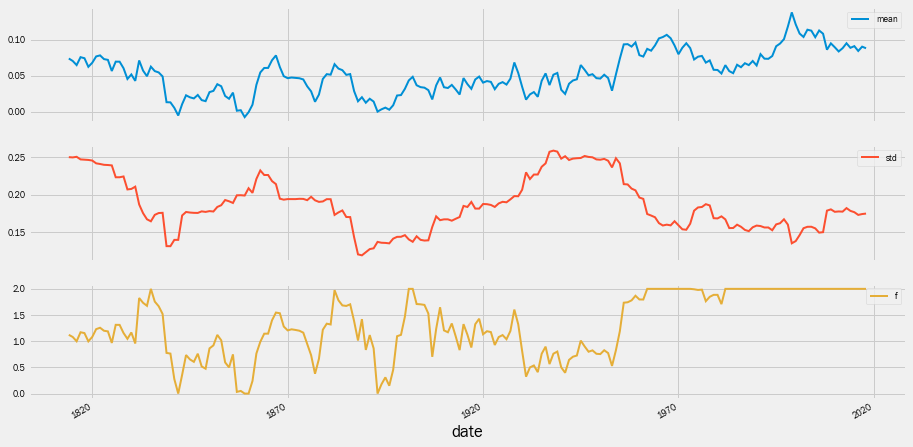

In [62]:
return_params.plot(subplots=True, lw=2, figsize=(14, 8));

In [76]:
annual_returns.tail()

,sp500,kelly
date,,
2014-12-31,0.113906,1.999996
2015-12-31,-0.007266,1.999996
2016-12-31,0.095350,1.999996
2017-12-31,0.194200,1.999996
2018-12-31,0.014815,1.999996


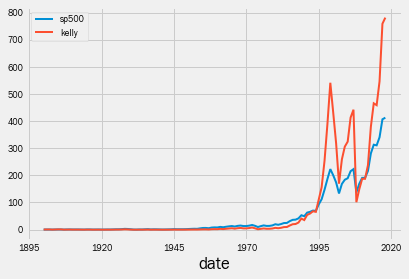

In [86]:
(annual_returns[['sp500']]
 .assign(kelly=annual_returns.sp500.mul(annual_returns.f.shift()))
 .dropna()
 .loc['1900':]
 .add(1)
 .cumprod()
 .sub(1)
 .plot(lw=2));


In [83]:
annual_returns.f.describe()

count    205.000000
mean       1.303795
std        0.585540
min        0.000003
25%        0.830339
50%        1.227349
75%        1.999996
max        1.999996
Name: f, dtype: float64

In [65]:
return_ci.head()

,mean,lower,upper,f
date,,,,
1814-12-31,0.074059,-0.426468,0.574586,1.122259
1815-12-31,0.070621,-0.429199,0.570442,1.081182
1816-12-31,0.064872,-0.436591,0.566336,0.998784
1817-12-31,0.075920,-0.418596,0.570436,1.170926
1818-12-31,0.074465,-0.419380,0.568309,1.155362


In [ ]:
sol = minimize_scalar(norm_integral, args=(m, s), bounds=[0., 2.], method='bounded')
print('Optimal Kelly fraction: {:.4f}'.format(sol.x))

In [ ]:

m = .058
s = .216
# Option 1: minimize the expectation integral

# Option 2: take the derivative of the expectation and make it null
x0 = newton(norm_dev_integral, .1, args=(m, s))
print('Optimal Kelly fraction: {:.4f}'.format(x0))

## Multiple Assets

In [92]:
with pd.HDFStore('../../00_data/assets.h5') as store:
    sp500_stocks = store['sp500/stocks'].index 
    prices = store['quandl/wiki/prices'].adj_close.unstack('ticker').filter(sp500_stocks)

In [93]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14277 entries, 1962-01-02 to 2018-03-27
Columns: 501 entries, MMM to ZTS
dtypes: float64(501)
memory usage: 54.7 MB


In [114]:
monthly_returns = prices.loc['1988':'2017'].resample('M').last().pct_change().dropna(how='all').dropna(axis=1)
stocks = monthly_returns.columns
monthly_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 359 entries, 1988-02-29 to 2017-12-31
Freq: M
Columns: 217 entries, MMM to XRX
dtypes: float64(217)
memory usage: 611.4 KB


In [115]:
cov = monthly_returns.cov()
inv_cov = pd.DataFrame(inv(cov), index=stocks, columns=stocks)

In [118]:
kelly_allocation = monthly_returns.mean().dot(inv_cov)

In [120]:
kelly_allocation.describe()

count    217.000000
mean       0.213979
std        3.493734
min      -10.840354
25%       -1.845360
50%        0.002192
75%        1.990041
max       11.316506
dtype: float64

In [173]:
kelly_allocation.sum()

46.43347236762423

In [134]:
TRADING_DAYS = 12

In [203]:
def pf_vol(weights, cov):
    return np.sqrt(weights.T @ cov @ weights)


def pf_ret(weights, mean_ret):
    return weights @ mean_ret


def pf_performance(weights, mean_ret, cov):
    r = pf_ret(weights, mean_ret)
    sd = pf_vol(weights, cov)
    return r, sd

In [204]:
n_assets = len(stocks)  # number of assets to allocate

x0 = np.full(n_assets, 1 / n_assets)
mean_asset_ret = monthly_returns.mean()
asset_cov = monthly_returns.cov()

In [205]:
def simulate_pf(mean_ret, cov):
    perf, weights = [], []
    for i in range(N_PORTFOLIOS):
        if i % 50000 == 0:
            print(i)
        weights = dirichlet([.08] * n_assets)
        weights /= np.sum(weights)

        r, sd = pf_performance(weights, mean_ret, cov)
        perf.append([r, sd, (r - RF_RATE) / sd])
    perf_df = pd.DataFrame(perf, columns=['ret', 'vol', 'sharpe'])
    return perf_df, weights

In [206]:
RF_RATE = 0
def neg_sharpe_ratio(weights, mean_ret, cov):
    r, sd = pf_performance(weights, mean_ret, cov)
    return -(r / sd)

def max_sharpe_ratio(mean_ret, cov):
    args = (mean_ret, cov)
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = ((-1, 1),) * n_assets
    return minimize(fun=neg_sharpe_ratio,
                    x0=x0,
                    args=args,
                    method='SLSQP',
                    bounds=bounds,
                    constraints=constraints)

In [207]:
res = max_sharpe_ratio(mean_asset_ret, asset_cov)

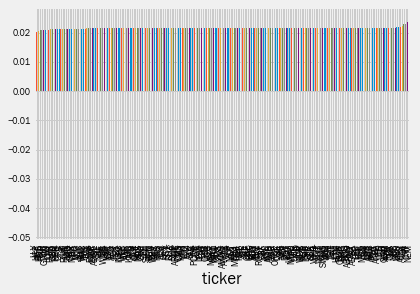

In [212]:
(res.x / kelly_allocation).sort_values().plot.bar()

In [154]:
def pf_volatility(w, r, c):
    return pf_performance(w, r, c)[1]


def efficient_return(mean_ret, cov, target):
    args = (mean_ret, cov)

    def ret_(weights):
        return pf_ret(weights, mean_ret)

    constraints = [{'type': 'eq', 'fun': lambda x: ret_(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]

    bounds = ((0.0, 1.0),) * n_assets

    # noinspection PyTypeChecker
    return minimize(pf_volatility,
                    x0=x0,
                    args=args, method='SLSQP',
                    bounds=bounds,
                    constraints=constraints)


def efficient_frontier(mean_ret, cov, ret_range):
    efficient_pf = []
    for ret in ret_range:
        efficient_pf.append(efficient_return(mean_ret, cov, ret))
    return efficient_pf

In [155]:
def calculate_efficient_frontier(mean_ret, cov):
    perf, wt = simulate_pf(mean_ret, cov)

    max_sharpe = max_sharpe_ratio(mean_ret, cov)
    max_sharpe_perf = pf_performance(max_sharpe.x, mean_ret, cov)
    wmax = max_sharpe.x
    print(np.sum(wmax))

    min_vol = min_variance(mean_ret, cov)
    min_vol_perf = pf_performance(min_vol['x'], mean_ret, cov)

    pf = ['Max Sharpe', 'Min Vol']
    alloc = pd.DataFrame(dict(zip(pf, [max_sharpe.x, min_vol.x])), index=assets)
    selected_pf = pd.DataFrame(dict(zip(pf, [max_sharpe_perf, min_vol_perf])),
                               index=['ret', 'vol'])

    print(selected_pf)
    print(perf.describe())

    perf.plot.scatter(x='vol', y='ret', c='sharpe',
                      cmap='YlGnBu', marker='o', s=10,
                      alpha=0.3, figsize=(10, 7), colorbar=True,
                      title='PF Simulation')

    r, sd = selected_pf['Max Sharpe'].values
    plt.scatter(sd, r, marker='*', color='r', s=500, label='Max Sharpe Ratio')
    r, sd = selected_pf['Min Vol'].values
    plt.scatter(sd, r, marker='*', color='g', s=500, label='Min volatility')
    plt.xlabel('Annualised Volatility')
    plt.ylabel('Annualised Returns')
    plt.legend(labelspacing=0.8)

    rmin = selected_pf.loc['ret', 'Min Vol']
    rmax = returns.add(1).prod().pow(1 / len(returns)).pow(TRADING_DAYS).sub(1).max()
    ret_range = np.linspace(rmin, rmax, 50)
    # ret_range = np.linspace(rmin, .22, 50)
    efficient_portfolios = efficient_frontier(mean_asset_ret, cov, ret_range)

    plt.plot([p['fun'] for p in efficient_portfolios], ret_range, linestyle='-.', color='black',
             label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)
    plt.tight_layout()
    plt.savefig('Calculated EF.png')


In [175]:
def min_variance(mean_ret, cov):
    args = (mean_ret, cov)
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = ((0, 1),) * n_assets

    return minimize(fun=pf_volatility,
                    x0=x0,
                    args=args,
                    method='SLSQP',
                    bounds=bounds,
                    constraints=constraints)

In [176]:
res = min_variance(mean_asset_ret, asset_cov)